In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import pandas
import sunode.wrappers.as_theano as sun


from scipy.integrate import ode
alpha  = -0.1
beta= 2
gamma=-2
delta=-0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha * state[0]**3 + beta*state[1]**3,
                  gamma*state[0]**3 + delta*state[1]**3])

t = np.linspace(0, 40,  80)              # time
X0 = np.array([2, 0])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y



np.random.seed(0)
yobs = X.T + np.random.normal(size=X.T.shape) * 0.02  #np.maximum(X.T + 2*np.random.randn(*X.T.shape),1)
#times = t
print(yobs.std(axis=0))

times = t[:40]    
times_test= t[40:]
yobs_test = yobs[40:]
yobs_norm = yobs[:40]



#yobs_norm = yobs # / yobs.std(axis=0)


## Do Bayesian Sindy
def nonlinear_oscillator_sunode_library(t, y, p):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    du_dt = 0.1 * p.pn[0] * y.u**3 + p.pn[1] * y.v**3 + p.pn[4] * y.u + p.pn[6] * y.v + p.pn[8] * y.u**2 + p.pn[10] * y.v**2 + p.pn[12] * y.u*y.v + p.pn[14] * y.u**2 * y.v + p.pn[16] * y.v**2 * y.u + p.pn[18]
    dv_dt = p.pn[2] * y.u**3 + 0.1 * p.pn[3] * y.v**3 + p.pn[5] * y.u + p.pn[7] * y.v + p.pn[9] * y.u**2 + p.pn[11] * y.v**2 + p.pn[13] * y.u*y.v + p.pn[15] * y.u**2 * y.v + p.pn[17] * y.v**2 * y.u + p.pn[19]
    return {'u': du_dt - 1e-5 * y.u**5, 'v' : dv_dt - 1e-5 * y.v**5}


model_rh = pm.Model()

d = 20

slab_df = 4
slab_scale = 2

with model_rh:

    #sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2) #  pm.Gamma('sigma',1,1,shape=2) #
    sigma = pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    
    
    l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    tau = pm.HalfStudentT('tau', nu=1, sigma=0.1)
    c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    lt = pm.Deterministic('lt', pm.math.sqrt(c2)*l / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l)))
    
    z  = pm.Normal('z', mu=0, sigma=1, shape=d)
    pn = pm.Deterministic('pn', z*tau*lt)
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=2)
    #xi = pm.Bernoulli('xi', 0.8, shape=d
    #pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Laplace('y0', mu=0, b=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])

with model_rh:

    #trace = pm.sample(2000, tune=2000, cores=2,random_seed=1,target_accept=0.9) #,start=start)

    #trace = pm.sample(2000, tune=2000, cores=2, random_seed=1, step_kwargs={'nuts':{'target_accept':0.9}})

    #trace_rh = pm.backends.load_trace('../nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/nonlinear_oscillator_normal_rh_20param_tune2000_noisep02_unscaled_gammap1_2.trace',model_rh)
    
    folder = '../nonlinear_oscillator/scaled_experiments/seeds_rh/'
    trace_rh = pm.backends.load_trace(folder + 'nonlinear_oscillator_normal_rh_20param_tune2000_noisep02_scaled_gammap1_1.trace',model_rh)


    #pm.summary(trace,var_names=['pn'])






[0.5743936  0.50086108]


In [2]:
model_ss = pm.Model()

d = 20

slab_df = 4
slab_scale = 2

with model_ss:

    #sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2) #  pm.Gamma('sigma',1,1,shape=2) #
    sigma = pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    
    
    #l = pm.HalfStudentT('l', nu=1, sigma=1, shape=d)
    #tau = pm.HalfStudentT('tau', nu=1, sigma=0.1)
    #c2 = pm.InverseGamma('c2', alpha=0.5*slab_df, beta=0.5*slab_df*slab_scale**2)
    
    #lt = pm.Deterministic('lt', pm.math.sqrt(c2)*l / pm.math.sqrt(c2 + pm.math.sqr(tau) * pm.math.sqr(l)))
    
    z  = pm.Laplace('z', mu=0, b=1, shape=d)
    #pn = pm.Deterministic('pn', z*tau*lt)
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=2)
    xi = pm.Bernoulli('xi', 0.8, shape=d)
    pn = pm.Deterministic('pn', z * xi)
    y0 = pm.Laplace('y0', mu=0, b=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])


    #trace = pm.sample(2000, tune=2000, cores=2, random_seed=2, step_kwargs={'nuts':{'target_accept':0.9}})

    folder = '../nonlinear_oscillator/scaled_experiments/seeds_rh/ss/'
    trace_ss = pm.backends.load_trace(folder + 'nonlinear_oscillator_normal_ss_20param_tune2000_noisep02_scaled_gammap1_2.trace')
    #trace = pm.sample(2000, tune=2000, cores=2, random_seed=[2,2], start=trace_ss, step_kwargs={'nuts':{'target_accept':0.9}})








3

In [70]:
model_gauss = pm.Model()

d = 20

slab_df = 4
slab_scale = 2

with model_gauss:

    #sigma = pm.Lognormal('sigma', mu=-1, sigma=1, shape=2) #  pm.Gamma('sigma',1,1,shape=2) #
    sigma = pm.Gamma('sigma',1,0.1,shape=2) 
    #pn = pm.Laplace('pn', mu=0, b=1, shape=d)
    
    
    pn  = pm.Normal('pn', mu=0, sigma=1, shape=d)
    
    #y0 = pm.Normal('y0',mu=yobs_norm[0,:], sigma=0.01, shape=2)
    #xi = pm.Bernoulli('xi', 0.8, shape=d
    #pnss = pm.Deterministic('pnss', pn * xi)
    y0 = pm.Laplace('y0', mu=0, b=1, shape=2)

    y_hat, _, problem, solver, _, _ = sun.solve_ivp(
        
        y0={
            'u': (y0[0], ()),
            'v': (y0[1], ()),
            },
            params={
                'pn' : (pn,d),
                'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
            },
            rhs=nonlinear_oscillator_sunode_library,
            make_solver='RK45',
            tvals=times,
            t0=times[0],
        )


    import sunode
    lib = sunode._cvodes.lib
    lib.CVodeSetMaxNumSteps(solver._ode, 1200)
    lib.CVodeSetMaxNumStepsB(solver._ode, solver._odeB, 1200)
    lib.CVodeSStolerances(solver._ode, 1e-6, 1e-6)
    lib.CVodeSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)
    lib.CVodeQuadSStolerancesB(solver._ode, solver._odeB, 1e-6, 1e-6)

    uobs = pm.Normal('uobs', mu=y_hat['u'][:], sigma=sigma[0], observed=yobs_norm[:,0])
    vobs = pm.Normal('vobs', mu=y_hat['v'][:], sigma=sigma[1], observed=yobs_norm[:,1])

    trace_gauss = pm.backends.load_trace('/home/hirshs/BayesianSindy-master/tabulated_runs/nonlinear_oscillator/scaled_experiments/seeds_rh_unscaled/nonlinear_oscillator_normal_gauss_20param_tune2000_noisep02_unscaled_gammap1_5.trace',model_gauss)

# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = [trace_gauss['pn'].T[[4,6,8,10,12,14,16,18,0,2],:][::-1], trace_gauss['pn'].T[[5,7,9,11,13,15,17,19,1,3],:][::-1]]
exps[0][1,:] = exps[0][1,:] *0.1
exps[1][0,:] = exps[1][0,:] *0.1

#exps = (trace_rh['pn'].T, trace_rh['pn'].T)
colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_gauss = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_gauss.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            #if np.abs(x.mean()) > 1:
            #    x = x/10
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,10.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-2,0,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(10) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$',
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                      r'$u^2 v$',
                      r'$v^2 u$',
                      r'$u^3$',
                      r'$v^3$'], fontsize=12)

    
#fig = matplotlib.pyplot.gcf()
#fig.set_size_inches(4, 5)
plt.close()
#plt.savefig('fig4b.pdf')

-1.960293321656123
-0.05544806733285146
-0.0024144501961943197
-0.048697176568045286
-0.009790716749603967
0.06018231454477614
-0.02364071280289412
0.02990563784931992
0.05155320766081754
-0.012995621251985723
-0.1339009069489328
1.90934651887151
-0.0003056284344206302
-0.10013769472714784
0.044522101236592726
-0.0435497540848617
-0.029927815733691035
0.029307260361187887
0.008392232754096327
0.01506508077349955


-1.9664974165172753
-0.0681942866865727
0.0013737679514228829
-0.0006382014697932648
-0.001042946716074994
0.004630598653875349
0.0008236276331406861
0.00024685169637337495
0.0011812609678668873
-0.00011916883545987772
-0.12452197340408948
2.007056212351071
0.0007737572905194834
-0.0029760541625853676
0.0006345774089680234
0.00021334684546867044
-0.00036473289318315893
-0.0003771612664168339
0.00028545971920340696
-0.00016817502935800172


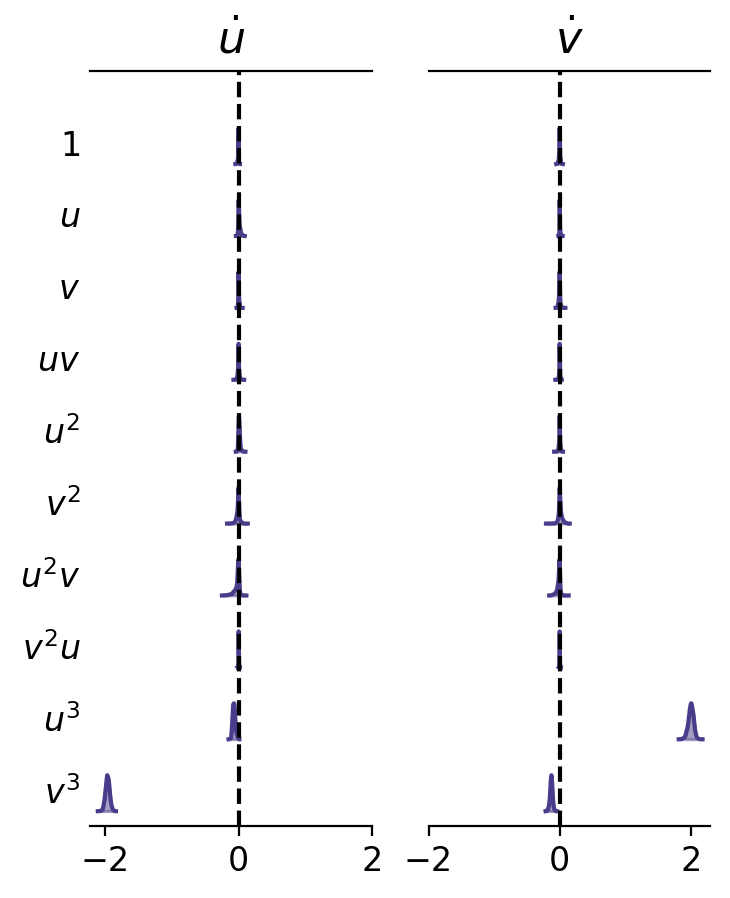

In [51]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000
exps = [trace_rh['pn'].T[[4,6,8,10,12,14,16,18,0,2],:][::-1], trace_rh['pn'].T[[5,7,9,11,13,15,17,19,1,3],:][::-1]]
exps[0][1,:] = exps[0][1,:] *0.1
exps[1][0,:] = exps[1][0,:] *0.1

#exps = (trace_rh['pn'].T, trace_rh['pn'].T)
colors = ['darkslateblue','darkslateblue']

fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        sns.kdeplot(data=v,color=colors[sbplt],ax=ax[sbplt])
        #if i==5 and sbplt==1:
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

res_rh = []
for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            res_rh.append(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            #if np.abs(x.mean()) > 1:
            #    x = x/10
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,10.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-2,0,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(10) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$',
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                      r'$u^2 v$',
                      r'$v^2 u$',
                      r'$u^3$',
                      r'$v^3$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig6b.pdf')

In [50]:
exps[0][1,:] *0.1

array([-0.06860624, -0.06964356, -0.07385359, ..., -0.06983792,
       -0.08200226, -0.06984479])

-1.965337155377732
-0.08002821716188127
3.6547554777617564e-05
-2.2605546463993174e-05
-0.00022561096466594543
2.5953388753212348e-05
3.462851649256582e-05
0.0001069990391017843
-5.850876160722485e-06
-2.3006695359148737e-05
-0.11951014505953764
2.028056850996283
-2.612624480110952e-05
-3.15370057027615e-06
1.4968518909930944e-05
5.549942930675733e-05
5.263906178713806e-06
-0.0002842842512631172
1.3687742353851859e-06
-4.5305461722190145e-05


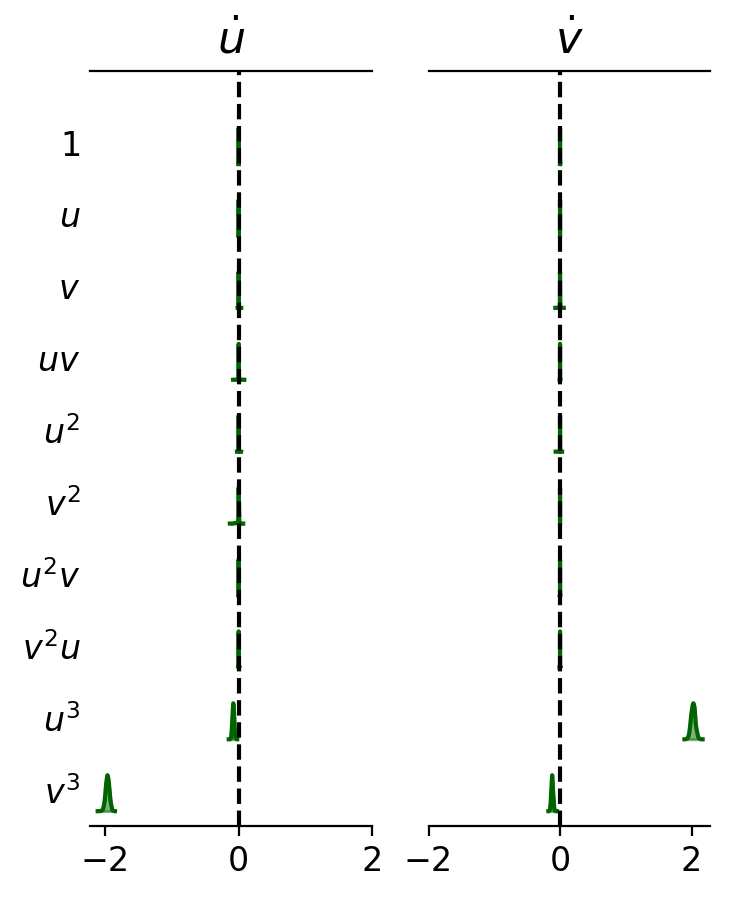

In [56]:
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

# create some data
n = 1000


exps = (trace_ss['pn'].T[[4,6,8,10,12,14,16,18,0,2],:][::-1], trace_ss['pn'].T[[5,7,9,11,13,15,17,19,1,3],:][::-1])
exps[0][1,:] = exps[0][1,:] *0.1
exps[1][0,:] = exps[1][0,:] *0.1

colors = ['darkgreen','darkgreen']

res_ss = []
fig, ax = plt.subplots(1,2,dpi=200)
for sbplt, var in enumerate(exps):
    for i, v in enumerate(var):
        #print(i)
        sns.kdeplot(data=v+np.random.randn(*v.shape)*0.0002,color=colors[sbplt],ax=ax[sbplt])
        #if (i==5 and sbplt==1) or (i==4 and sbplt==0) :
        #    sns.kdeplot(data=var[-1,:],color=colors[sbplt],ax=ax[sbplt])

for r in range(2):    
# find the line and rescale y-values
    children = ax[r].get_children()
    c = 0
    for child in children:
        if isinstance(child, matplotlib.lines.Line2D):
            x, y = child.get_data()
            print(x[np.argmax(y)])
            y = y/y.max() * 0.5 + c + 0.2
            res_ss.append(x[np.argmax(y)])
            child.set_data(x,y)
            ax[r].fill_between(x,c + 0.2, y, alpha=0.5,color=colors[r])
            c+= 1
        
for i in range(2):
    ax[i].set_ylim([0,10.5])
    #ax[i].set_xlabel('Coefficient value', fontsize=14)
    ax[i].set_ylabel('')
    ax[i].set_title([r'$\dot{u}$',r'$\dot{v}$'][i % 2], fontsize=16)
    ax[i].plot([0, 0], [0, 20], 'k--')
    ax[i].set_yticks([])  
    ax[i].tick_params(axis='x', which='major', labelsize=12)
    ax[i].spines['left'].set_visible(False)
    ax[i].spines['right'].set_visible(False)
    ax[i].set_xticks([-2,0,2])
    #ax[i].axis('off')
    
ax[0].set_yticks(np.arange(10) + 0.5)
#ax[0].set_yticks(np.array([0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55]) * 0.85 - 0.01)
#ax[0].set_yticklabels([ r'$\dot{u} \ \colon \ u$', r'$\dot{v} \ \colon \ u$',
#                    r'$\dot{u} \ \colon \ v$', r'$\dot{v} \ \colon \ v$',
#                    r'$\dot{u} \ \colon \ u v$', r'$\dot{v} \ \colon \ u v$',
#                    r'$\dot{u} \ \colon \ u^2$', r'$\dot{v} \ \colon \ u^2$',
#                    r'$\dot{u} \ \colon \ v^2$', r'$\dot{v} \ \colon \ v^2$',
#                    r'$\dot{v} \ \colon \ 1$', r'$\dot{u} \ \colon \ 1$'][:6], fontsize=16)

ax[0].set_yticklabels([ r'$1$',
                       r'$u$',
                    r'$v$', 
                    r'$ u v$', 
                    r'$u^2$', 
                    r'$v^2$', 
                      r'$u^2 v$',
                      r'$v^2 u$',
                      r'$u^3$',
                      r'$v^3$'][::-1], fontsize=12)
ax[0].yaxis.set_tick_params(length=0)

    
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(4, 5)
plt.savefig('fig6a.pdf')

In [6]:
# plot mean and intervals
with model_ss:
    ppc_ss = pm.sample_posterior_predictive(trace_ss, samples=8000,var_names=['uobs','vobs'], random_seed=2)

100%|██████████| 8000/8000 [00:29<00:00, 270.98it/s]


In [7]:
with model_rh:
    ppc_rh = pm.sample_posterior_predictive(trace_rh, samples=8000,var_names=['uobs','vobs'], random_seed=2)

100%|██████████| 8000/8000 [00:58<00:00, 137.19it/s]


In [28]:
# Apply sindy to data
from scipy.integrate import ode, solve_ivp
alpha  = -0.1
beta= 2
gamma=-2
delta=-0.1
def dX_dt(t, state,par):
    """ Return the growth rate of fox and rabbit populations. """
    alpha,beta,gamma,delta = par
    return np.array([ alpha * state[0]**3 + beta*state[1]**3,
                  gamma*state[0]**3 + delta*state[1]**3])

t = np.linspace(0, 20,  100)              # time
X0 = np.array([2, 0])                    # initials conditions: 10 rabbits and 5 foxes
r = ode(dX_dt).set_integrator('dopri5')
r.set_initial_value(X0, t[0])
r.set_f_params((alpha,beta,gamma,delta))
X = np.zeros((len(X0),len(t)))
X[:,0] = X0
for i, _t in enumerate(t):
    if i == 0:
        continue
    r.integrate(_t)
    X[:, i] = r.y

import pysindy as ps
from pysindy.differentiation import SmoothedFiniteDifference
sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
#dx = sfd(inp)
data = yobs_norm
dx = sfd(data)
optimizer = ps.STLSQ(threshold=0.2)
feature_library = ps.PolynomialLibrary(degree=3)
model = ps.SINDy(feature_names=["x", "y"],optimizer=optimizer,feature_library=feature_library)
model.fit(data, t=times)
sim = model.simulate(data[0],times,hmin=1e-8)
model.print()

x' = 0.477 1 + 0.513 x + 0.882 y + -1.844 x^2 + -0.407 x y + 0.394 y^2 + -1.397 x^3 + 1.409 x y^2
y' = -0.594 x + -0.387 x^2 + 0.322 y^2 + -0.511 x^3 + 0.306 x^2 y + -0.328 x y^2


/home/hirshs/anaconda3/envs/mars-sunode/lib/python3.7/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Repeated error test failures (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


{'differentiation_method': <pysindy.differentiation.finite_difference.FiniteDifference at 0x7fc0a661a710>,
 'discrete_time': False,
 'feature_library__degree': 3,
 'feature_library__include_bias': True,
 'feature_library__include_interaction': True,
 'feature_library__interaction_only': False,
 'feature_library__order': 'C',
 'feature_library': PolynomialLibrary(degree=3, include_bias=True, include_interaction=True,
                   interaction_only=False, order='C'),
 'feature_names': ['x', 'y'],
 'n_jobs': 1,
 'optimizer__alpha': 0.1,
 'optimizer__copy_X': True,
 'optimizer__fit_intercept': False,
 'optimizer__max_iter': 20,
 'optimizer__normalize': False,
 'optimizer__ridge_kw': None,
 'optimizer__threshold': 0.2,
 'optimizer': STLSQ(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=20, normalize=False,
       ridge_kw=None, threshold=0.2)}

In [ ]:
solve_ivp(X0)

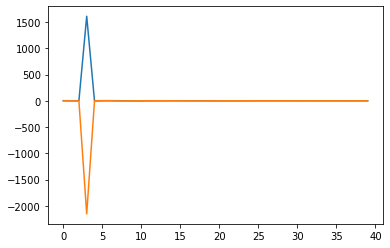

In [27]:
plt.figure()
plt.plot(sim)
plt.show()

In [ ]:
2

In [ ]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_rh[name[i]].T 
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 5,95
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2)
    
    plt.plot(times,sim[:, 0], "-", color='red',label="SINDy model", linewidth=2)
    plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:40,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population',fontsize=22)

plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T 
    
    #for j in range(1,100):
    #    a,b = 0.05*j,100-0.05*j
    #    above = np.percentile(series,a,axis=1)
    #    below = np.percentile(series,b,axis=1)
    #    plt.fill_between(times, below, above, color=colors[i], alpha=0.004)
    
    a,b = 5,95
    above = np.percentile(series,a,axis=1)
    below = np.percentile(series,b,axis=1)
    plt.fill_between(times, below, above, color=colors[i], alpha=0.2)
    
    #plt.plot(times,sim[:, 0], "-", color='red',label="SINDy model", linewidth=2)
    #plt.plot(times,sim[:, 1], "-", color='blue',label="SINDy model", linewidth=2)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    #plt.plot(times,sim[:, 0]*np.std(yobs,axis=0)[0], "-.", color='red',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.plot(times,sim[:, 1]*np.std(yobs,axis=0)[1], "-.", color='blue',alpha=0.15,label="SINDy model", linewidth=3)
    #plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs[:40,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xlabel('Time [years]',fontsize=22)
    plt.ylabel('Population',fontsize=22)
    

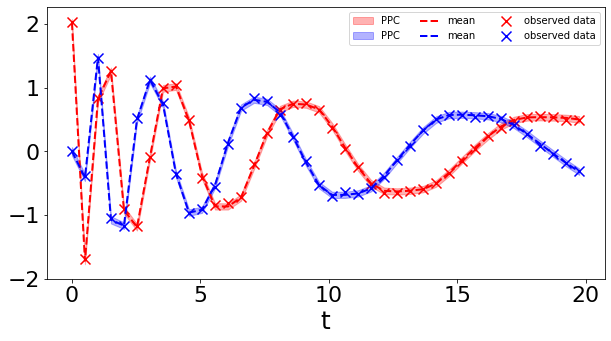

In [11]:
plt.figure(figsize=(10,5))
ax = plt.gca()
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_rh[name[i]].T
    above = np.percentile(series,99,axis=1)
    below = np.percentile(series,1,axis=1)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(times, below, above, color=colors[i], alpha=0.3,label='PPC')
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.xticks([0,5,10,15,20],fontsize=22)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
handles, labels = ax.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
ax.legend(handles, labels,ncol=3)
#plt.legend(ncol=3)
plt.xlabel('t',fontsize=25)
plt.savefig('legend.pdf')

In [12]:
def nonlinear_oscillator_sunode_library_mat(t, y, pn):
    #state = np.array([y.u**3, y.v**3])
    #res = p.pn @ state 
    u,v = y
    state = np.array([u**3, v**3,u,v,u**2,v**2,u*v,u**2 * v, v**2 * u,1]) 
    #return state @ np.reshape(pn,(10,2),'C')
    return np.array([0.1 * pn[0] * u**3 + pn[1] * v**3 + pn[4] * u + pn[6] * v + pn[8] * u**2 + pn[10] * v**2 + pn[12] * u*v + pn[14] * u**2 * v + pn[16] * v**2 * u + pn[18],
     pn[2] * u**3 + 0.1 * pn[3] * v**3 + pn[5] * u + pn[7] * v + pn[9] * u**2 + pn[11] * v**2 + pn[13] * u*v + pn[15] * u**2 * v + pn[17] * v**2 * u + pn[19]])
    #return {'u': du_dt - 1e-5 * y.u**5, 'v' : dv_dt - 1e-5 * y.v**5}
    
    

In [13]:
# plot mean and intervals
with model_ss:
    ppc_forecast_ss = pm.sample_posterior_predictive(trace_ss, samples=8000,var_names=['y0','pn','sigma'], random_seed=2)


t = np.linspace(0, 40,  80)              # time
credibility_interval_ss = np.zeros((500,2,len(t)))
for k in range(500):
    y0 = ppc_forecast_ss['y0'][k]                  # initials conditions: 10 rabbits and 5 foxes
    pn = ppc_forecast_ss['pn'][k]
    sigma = ppc_forecast_ss['sigma'][k]
    r = ode(nonlinear_oscillator_sunode_library_mat).set_integrator('dopri5')
    r.set_initial_value(y0, t[0])
    r.set_f_params(pn)
    credibility_interval_ss[k,:,0] = y0
    for i, _t in enumerate(t):
        if i == 0:
            continue
        r.integrate(_t)
        credibility_interval_ss[k,:, i] = r.y + np.random.randn(*r.y.shape) * sigma
    if k % 100 == 0:
        print(k)


'''
y0 = ppc_forecast['y0'][0]   
pn = ppc_forecast['pn'][0]      
    
y_hat, _, _, _ = s.solve_ivp(y0={
        'u': (y0[0], ()),
        'v': (y0[1], ()),
        },
        params={
            'pn' : (pn,d),
            'tmp': np.zeros(1),  # Theano wants at least one fixed parameter
        },
        rhs=nonlinear_oscillator_sunode_library,
        make_solver='RK45',
        tvals=times,
        t0=times[0],
    )
    '''

100%|██████████| 8000/8000 [00:02<00:00, 3344.73it/s]


0
100
200
300
400


"\ny0 = ppc_forecast['y0'][0]   \npn = ppc_forecast['pn'][0]      \n    \ny_hat, _, _, _ = s.solve_ivp(y0={\n        'u': (y0[0], ()),\n        'v': (y0[1], ()),\n        },\n        params={\n            'pn' : (pn,d),\n            'tmp': np.zeros(1),  # Theano wants at least one fixed parameter\n        },\n        rhs=nonlinear_oscillator_sunode_library,\n        make_solver='RK45',\n        tvals=times,\n        t0=times[0],\n    )\n    "

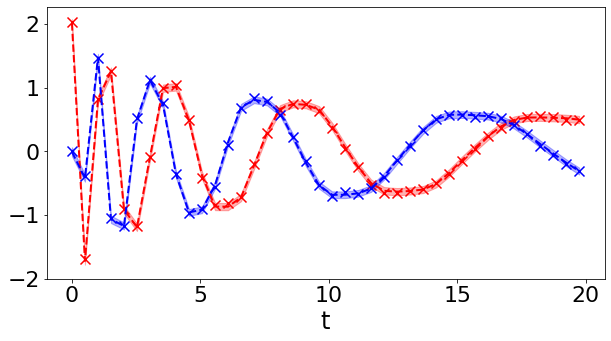

In [14]:
plt.figure(figsize=(10,5))
name = ['uobs','vobs']
colors = ['r','b']
for i in range(2):
    series = ppc_ss[name[i]].T
    above = np.percentile(series,99.5,axis=1)
    below = np.percentile(series,0.5,axis=1)
    mu = series.mean(axis=1)
    plt.plot(times, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(times, below, above, color=colors[i], alpha=0.3)
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=100, alpha=1.0, label="observed data");
    plt.xticks([0,5,10,15,20],fontsize=22)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
    plt.xlabel('t',fontsize=24)

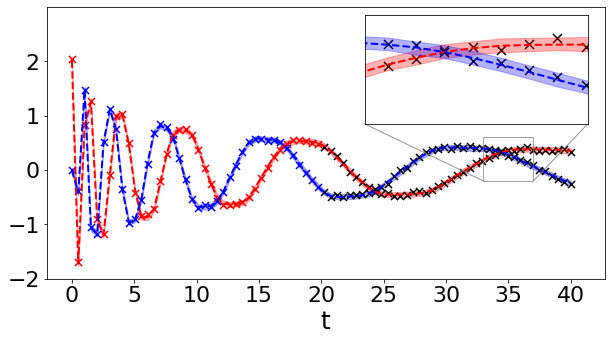

In [15]:
fig, ax= plt.subplots(figsize=(10,5))
ax = plt.subplot(1,1,1)
name = ['uobs','vobs']
colors = ['r','b']
axins = ax.inset_axes([0.57, 0.57, 0.4, 0.4])
for i in range(2):
    series = credibility_interval_ss[:,i,:].T
    above = np.percentile(series,99,axis=1)
    below = np.percentile(series,1,axis=1)
    #mu = series.mean(axis=1)
    #plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(t, below, above, color=colors[i], alpha=0.3)
    #plt.plot(np.hstack((times,times_test)),sim[:,i])
    mu = series.mean(axis=1)
    plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=50, alpha=1.0, label="observed data");
    plt.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=50,alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xticks([0,5,10,15,20,25,30,35,40],fontsize=22)
    axins.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=80,alpha=1.0, label="observed data");
    axins.fill_between(t, below, above, color=colors[i], alpha=0.3)
    axins.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    axins.set_xlim([33,37])
    axins.set_ylim([-0.2,0.6])
    plt.yticks([-2,-1,0,1,2,3],fontsize=22)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    axins.set_yticks([])
    axins.set_xticks([])
    ax.indicate_inset_zoom(axins)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
    plt.xlabel('t',fontsize=25)

In [16]:
# plot mean and intervals
with model_rh:
    ppc_forecast_rh = pm.sample_posterior_predictive(trace_rh, samples=8000,var_names=['y0','pn','sigma'], random_seed=2)

t = np.linspace(0, 40,  80)              # time
credibility_interval_rh = np.zeros((500,2,len(t)))
for k in range(500):
    y0 = ppc_forecast_rh['y0'][k]                  # initials conditions: 10 rabbits and 5 foxes
    pn = ppc_forecast_rh['pn'][k]
    sigma = ppc_forecast_ss['sigma'][k]
    r = ode(nonlinear_oscillator_sunode_library_mat).set_integrator('dopri5')
    r.set_initial_value(y0, t[0])
    r.set_f_params(pn)
    credibility_interval_rh[k,:,0] = y0
    for i, _t in enumerate(t):
        if i == 0:
            continue
        r.integrate(_t)
        credibility_interval_rh[k,:, i] = r.y + np.random.randn(*r.y.shape) * sigma
    if k % 100 == 0:
        print(k)


100%|██████████| 8000/8000 [00:04<00:00, 1800.53it/s]


0
100
200
300
400


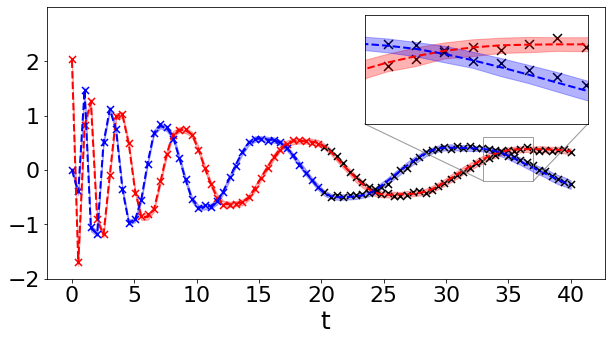

In [17]:
fig, ax= plt.subplots(figsize=(10,5))
ax = plt.subplot(1,1,1)
name = ['uobs','vobs']
colors = ['r','b']
axins = ax.inset_axes([0.57, 0.57, 0.4, 0.4])
for i in range(2):
    series = credibility_interval_rh[:,i,:].T
    above = np.percentile(series,99,axis=1)
    below = np.percentile(series,1,axis=1)
    #mu = series.mean(axis=1)
    #plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.fill_between(t, below, above, color=colors[i], alpha=0.3)
    #plt.plot(np.hstack((times,times_test)),sim[:,i])
    mu = series.mean(axis=1)
    plt.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    plt.scatter(times, yobs_norm[:,i], color=colors[i],marker='x',s=50, alpha=1.0, label="observed data");
    plt.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=50,alpha=1.0, label="observed data");
    plt.xticks(fontsize=22)
    plt.ylim(-2,2)
    plt.xticks([0,5,10,15,20,25,30,35,40],fontsize=22)
    axins.scatter(times_test, yobs_test[:,i], color='k',marker='x',s=80,alpha=1.0, label="observed data");
    axins.fill_between(t, below, above, color=colors[i], alpha=0.3)
    axins.plot(t, mu, '--', color=colors[i], lw=2, label="mean");
    axins.set_xlim([33,37])
    axins.set_ylim([-0.2,0.6])
    plt.yticks([-2,-1,0,1,2,3],fontsize=22)
    axins.set_xticklabels('')
    axins.set_yticklabels('')
    axins.set_yticks([])
    axins.set_xticks([])
    ax.indicate_inset_zoom(axins)
    plt.yticks([-2,-1,0,1,2],fontsize=22)
    plt.xlabel('t',fontsize=25)

In [62]:
# Spike and slab inclusion probabilities
np.vstack((trace_ss['xi'].mean(axis=0)[[4,6,8,10,12,14,16,18,0,2]],
trace_ss['xi'].mean(axis=0)[[5,7,9,11,13,15,17,19,1,3]],)).T

array([[0.0000e+00, 1.7500e-03],
       [7.5000e-04, 2.5000e-04],
       [3.0750e-02, 1.0700e-01],
       [9.9000e-02, 1.0000e-02],
       [8.2000e-02, 4.8500e-02],
       [1.6625e-01, 0.0000e+00],
       [1.0000e-03, 3.7500e-03],
       [3.0250e-02, 1.1000e-02],
       [1.0000e+00, 1.0000e+00],
       [1.0000e+00, 1.0000e+00]])

In [83]:
# regularized horseshoe inclusion probabilities
(res_rh / np.array(res_gauss)).reshape(10,2,order='F')[::-1,:]

array([[ 0.00916992, -0.01116323],
       [ 0.02291343,  0.03401475],
       [ 0.00825435, -0.01286921],
       [-0.03483937,  0.01218709],
       [ 0.07694285, -0.00489892],
       [ 0.10652404,  0.01425309],
       [ 0.01310551,  0.02971962],
       [-0.56897755, -2.53169275],
       [ 1.22987671,  1.05117442],
       [ 1.00316488,  0.92995616]])

In [76]:
np.array(res_gauss).reshape(10,2,order='F')[::-1,:]

array([[-1.29956213e-02,  1.50650808e-02],
       [ 5.15532077e-02,  8.39223275e-03],
       [ 2.99056378e-02,  2.93072604e-02],
       [-2.36407128e-02, -2.99278157e-02],
       [ 6.01823145e-02, -4.35497541e-02],
       [-9.79071675e-03,  4.45221012e-02],
       [-4.86971766e-02, -1.00137695e-01],
       [-2.41445020e-03, -3.05628434e-04],
       [-5.54480673e-02,  1.90934652e+00],
       [-1.96029332e+00, -1.33900907e-01]])

In [64]:
np.array(res_rh).reshape(10,2,order='F')[::-1,:]

array([[-1.19168835e-04, -1.68175029e-04],
       [ 1.18126097e-03,  2.85459719e-04],
       [ 2.46851696e-04, -3.77161266e-04],
       [ 8.23627633e-04, -3.64732893e-04],
       [ 4.63059865e-03,  2.13346845e-04],
       [-1.04294672e-03,  6.34577409e-04],
       [-6.38201470e-04, -2.97605416e-03],
       [ 1.37376795e-03,  7.73757291e-04],
       [-6.81942867e-02,  2.00705621e+00],
       [-1.96649742e+00, -1.24521973e-01]])

In [60]:
np.array(res_ss).reshape(10,2,order='F')[::-1,:]

array([[-2.30066954e-05, -4.53054617e-05],
       [-5.85087616e-06,  1.36877424e-06],
       [ 1.06999039e-04, -2.84284251e-04],
       [ 3.46285165e-05,  5.26390618e-06],
       [ 2.59533888e-05,  5.54994293e-05],
       [-2.25610965e-04,  1.49685189e-05],
       [-2.26055465e-05, -3.15370057e-06],
       [ 3.65475548e-05, -2.61262448e-05],
       [-8.00282172e-02,  2.02805685e+00],
       [-1.96533716e+00, -1.19510145e-01]])

In [ ]:
trace